In [9]:
import numpy.random as random
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import cvxpy as cp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})
plt.rc('axes', prop_cycle=cycler('linestyle', ['-', '--', ':', '-.']))

In [10]:
# Generate problem
random.seed(1)
m, n = 100, 500
A = random.randn(m, n)
b = random.randn(m)
gamma = 4

def f(x):
    return .5 * np.linalg.norm(np.dot(A, x) - b, 2)**2 + \
        gamma * np.linalg.norm(x, 1)


def soft_thresh(x, mu):
    return np.maximum(x - mu, 0) - \
        np.maximum(-x - mu, 0)


k_vec = np.arange(1000)

x0 = random.randn(n)

In [11]:
# Solve with cvxpy
x_cp = cp.Variable(n)
f_star = cp.Problem(
    cp.Minimize(.5 * cp.sum_squares(A @ x_cp - b) + gamma * cp.norm(x_cp, 1))
).solve(solver=cp.ECOS, abstol=1e-10, reltol=1e-10)
x_star = x_cp.value

In [12]:
# ISTA
x_hist_ista = [x0]
subopt_hist_ista = [(f(x0) - f_star)/f_star]
t_ista = 0.001
for k in k_vec:
    x_cur = x_hist_ista[-1]
    x_next = x_cur - t_ista * A.T.dot(A.dot(x_cur) - b)
    x_next = soft_thresh(x_next, t_ista * gamma)
    x_hist_ista.append(x_next)
    subopt_hist_ista.append((f(x_next) - f_star)/f_star)
    # NB. For plotting, not realistic termination
    if subopt_hist_ista[-1] < 1e-06:
        break

In [13]:
# FISTA
x_hist_fista = [x0]
y_hist_fista = [x0]
subopt_hist_fista = [(f(x0) - f_star)/f_star]
t_fista = 0.001
lam = 1

for k in k_vec:
    x_cur = x_hist_fista[-1]
    y_cur = y_hist_fista[-1]
    x_next = y_cur - t_fista * A.T.dot(A.dot(y_cur) - b)
    x_next = soft_thresh(x_next, t_fista * gamma)
    x_hist_fista.append(x_next)
    subopt_hist_fista.append((f(x_next) - f_star)/f_star)

    lam_prev = lam
    lam = 0.5 * (1 + np.sqrt(1 + 4 * lam_prev**2))
    y_next = x_next + ((lam_prev - 1)/lam)* (x_next - x_cur)
    y_hist_fista.append(y_next)

    # NB. For plotting, not realistic termination
    if subopt_hist_fista[-1] < 1e-06:
        break

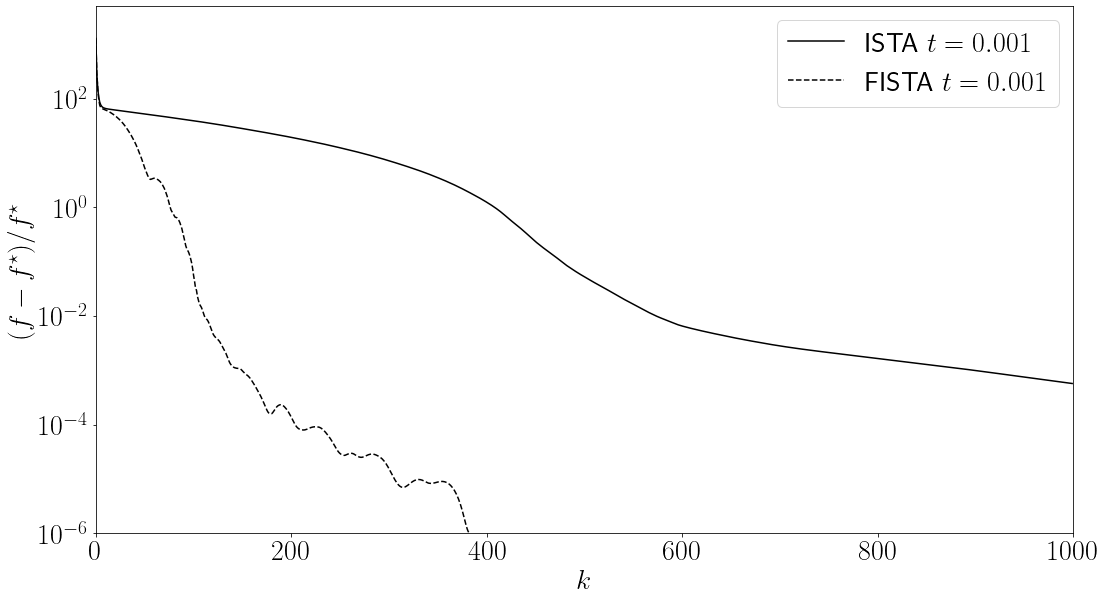

In [15]:
# Plot
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(k_vec, subopt_hist_ista[:-1], color="k",
        label=r"$\mbox{ISTA}\;t = %.3f$" % t_ista)
ax.plot(k_vec[:len(subopt_hist_fista)], subopt_hist_fista, color="k",
        label=r"$\mbox{FISTA}\;t = %.3f$" % t_fista)
ax.set_yscale('log')
ax.set_ylabel(r"$(f - f^\star)/f^\star$")
ax.set_xlabel(r"$k$")
ax.set_xlim([0, 1000])
ax.set_ylim([1e-06, 5e03])
ax.legend()


plt.tight_layout()
plt.savefig("fista.pdf")